# EN3160 Assignment 2 on Fitting and Alignment

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1 Blob Detection

Laplacian of Gaussian\
$∇²_{norm}g = \sigma^2(\frac{∂²g}{∂x²} + \frac{∂²g}{∂y²})$



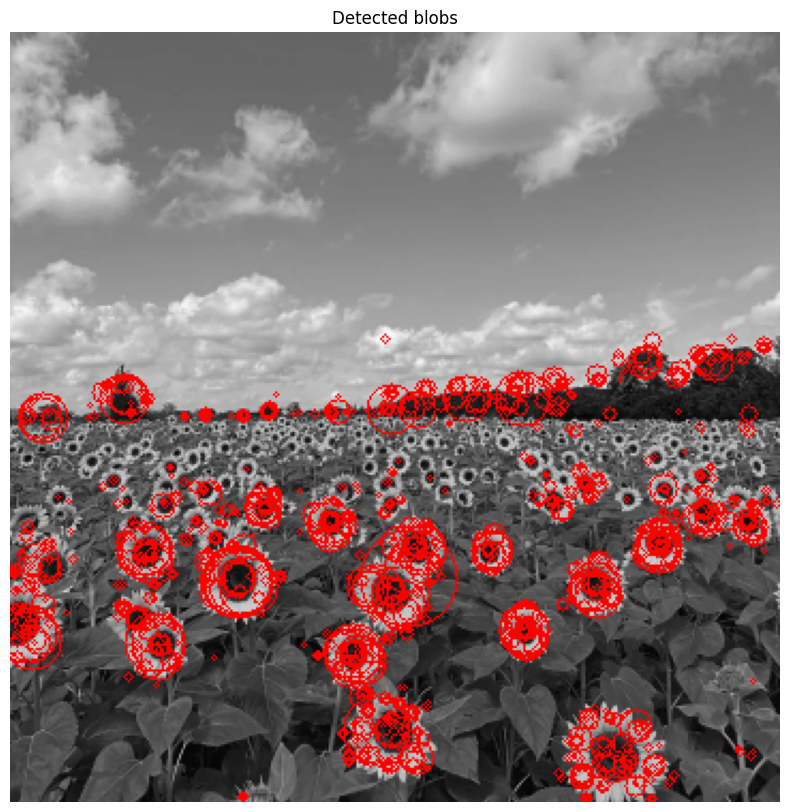

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load image
im = cv.imread('img/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
assert im is not None

# Get grayscale image
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

# Select range of sigma
sigma_values = np.linspace(2,4,6,8)
# Threhsold for blob detection
threshold = 0.4

# Store responses of each scale
blob_responses = []

for sigma in sigma_values:

    # Apply Gaussian blur
    gaussian_blur = cv.GaussianBlur(gray, (0, 0), sigma)
    # Compute Laplacian of Gaussian (LoG)
    laplacian = cv.Laplacian(gaussian_blur, cv.CV_64F)

    # Get absolute value
    blob_response = np.abs(laplacian)

    # Threshold the response and get contours
    mask = blob_response > threshold * blob_response.max()
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw contours as circles
    for contour in contours:
        if len(contour) >= 5:
            # Get the center and radius of the enclosing circle from contour
            (center_x, center_y), radius = cv.minEnclosingCircle(contour)
            # Convert to integers
            center = (int(center_x), int(center_y))
            radius = int(radius)
            blob_responses.append((center, radius, sigma))

# Draw all detected circles with the specified line thickness
output = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)
for blob in blob_responses:
    center, radius, _ = blob
    cv.circle(output, center, radius, (0, 0, 255), 1)

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected blobs')
plt.show()

In [16]:
# Get largest circle
blobs_sorted = sorted(blob_responses, key=lambda x: x[1], reverse=True)
largest_blob = blobs_sorted[0]
center, radius, sigma = largest_blob

# Print largest circle details
print(f"Largest blob at : {center} with radius {radius} and sigma {sigma}")

Largest blob at : (186, 255) with radius 23 and sigma 3.2


# 2 Line fitting and circle fitting using RANSAC

## Noisy Point Set Generation

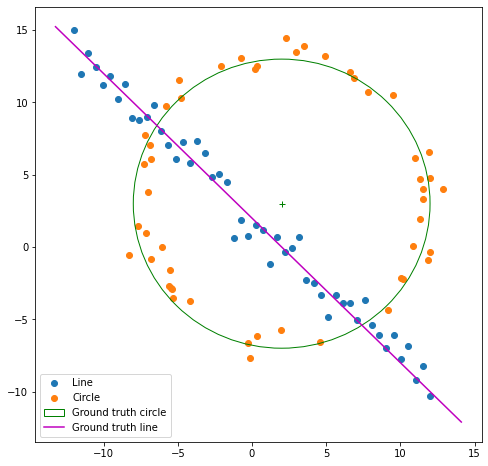

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# Constants
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

# Generate random points for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generate random points for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine all points
X = np.vstack((X_circ, X_line))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the line points
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

# Scatter plot for the circle points
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


## Line Estimation using RANSAC

In [ ]:
import math
N = X.shape[0]
dataset = X

def line_equation_from_points(x1, y1, x2, y2):
    """ Return the line equation in the form ax + by = d"""
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    return a, b, d

def line_tls(x, indices):
    """ Return the total least squares error for the line model"""
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    """ Constraint """
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    """ Computing the inliners """
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.027438079236716e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.004320888847483e-09
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.9449075781056605e-12
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1542882001468292e-09
            Iterations: 9
            Function evaluations: 42
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.899136426982486e-13
            Iterations: 6
            Func

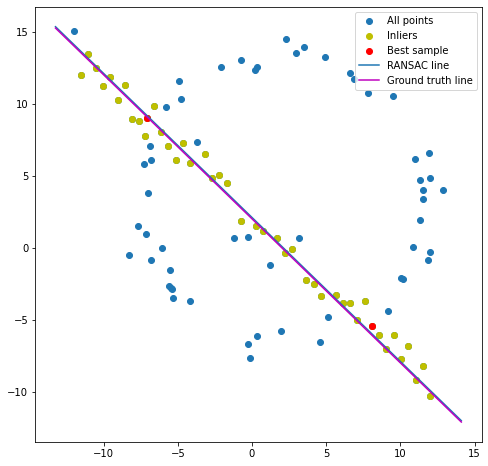

In [ ]:
t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []                                                                                                           # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = []                                                                                                            # Best model normal (a, b) and distance from origin d
best_error = np.inf 
best_sample_line = []                                                                                                               # Three-point sample leading to the best model computation
res_only_with_sample = []                                                                                                           # Result (a, b, d) only using the best sample
best_inliers_line = []                                                                                                          # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, t) # Computing the inliers
    if inliers_line.sum() > d:
        x0 = res.x
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        if res.fun < best_error:
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1

print('Best line model', best_model_line)

print(dataset.shape)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

## Circle Estimation using RANSAC for the Remnant

(56, 2)


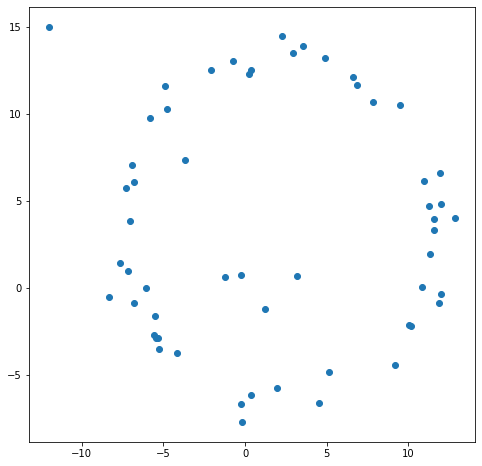

In [ ]:
from scipy import optimize
import random

# Extract the outliers (data points that are not inliers)
outliers_indices = np.where(np.logical_not(best_inliers_line))[0]
outliers_data = dataset[outliers_indices, :]
#print(outliers_data)
print(outliers_data.shape)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(outliers_data[:,0],outliers_data[:,1], label='All points')

N = outliers_data.shape[0]

def circle_equation(points):
    """ Return the center and radius of the circle from three points """
    p1,p2,p3 = points[0], points[1], points[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """ Returns the list of inliers to a model of a circle from a set of points. The threshold value is taken as 1/3 rd of the radius """
    inliers = []
    thresh = r//5

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """ Returns a list of 3 random samples from a given list """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))
    xc_2, yc_2 = center_2
    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    return (xc_2, yc_2), R_2

In [ ]:
# RANSAC_Circle
def RANSAC_Circle(data_list, itr):
    """ Return the center, radius and the best sample and its inliers 
    used to fit the circle to a set of points using RANSAC_Circle """
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = 20
    
    for i in range(itr):
        samples = random_sample(data_list)  # Generating a random sample of 3 points
        center, radius = circle_equation(samples) # Calculting the center and radius of the circle created by the 3 points
        inliers = get_inliers(data_list, center, radius) # Get the list of inliers
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

Center of Sample= (2.1740634716442275, 9.922203877357038)
Radius of Sample= 15.060843136262823
(56, 2)
[[ 11.33688356   1.94532686]
 [ -7.02726063   3.8270372 ]
 [ 10.98576125   6.13411788]
 [ -5.51637911  -1.57094455]
 [ -2.11883512  12.52482616]
 [ -5.30267711  -3.49872868]
 [  9.4733906   10.53305359]
 [ -0.28036336  -6.66558447]
 [ 10.013154    -2.11273967]
 [ 12.86397788   4.00246701]
 [ -0.16237337  -7.68830231]
 [  9.19768511  -4.38752859]
 [  0.36206961  12.52815163]
 [ -6.83518888   6.07353422]
 [  1.92705585  -5.75581326]
 [ 11.29303833   4.70340354]
 [ -4.92348701  11.58891705]
 [  2.27714338  14.45309134]
 [  4.92414741  13.23777177]
 [ -5.8110729    9.77068763]
 [ -7.29209139   5.77686632]
 [ -5.44767932  -2.83429718]
 [ -7.16059886   0.95962634]
 [ 11.94403779   6.59385236]
 [ -5.60462048  -2.67596425]
 [ -4.19081016  -3.72760856]
 [ -6.79158059  -0.84094597]
 [  6.86518959  11.68469997]
 [ 11.54975407   3.98014323]
 [ 10.16672569  -2.18846882]
 [ -0.74033439  13.05903649

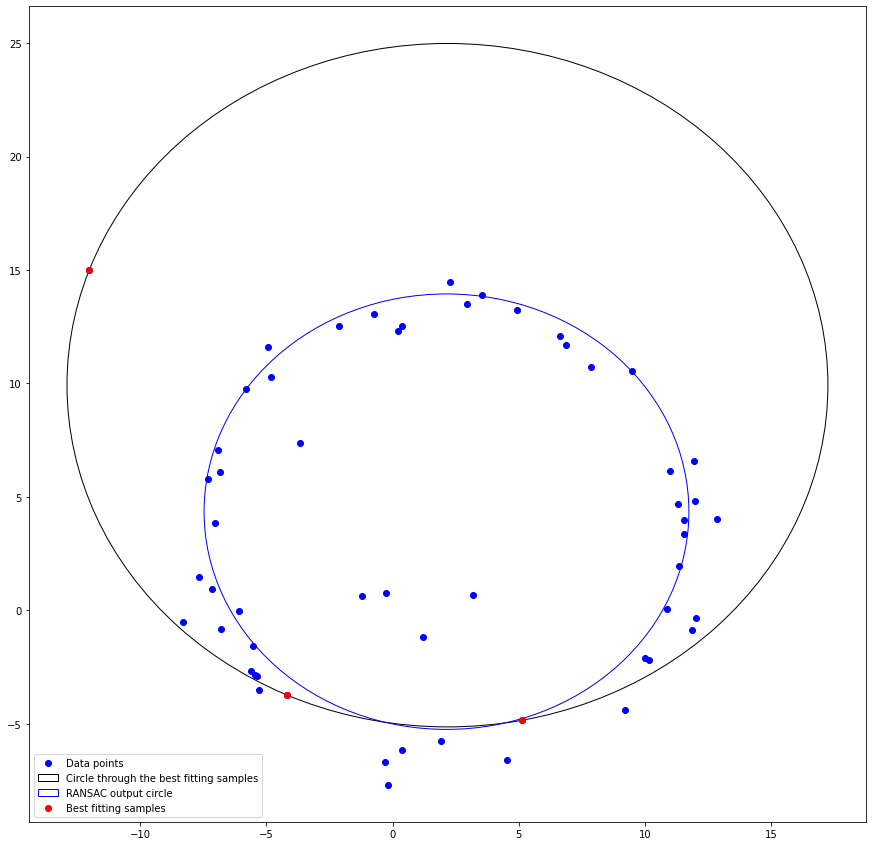

In [ ]:
# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(outliers_data, 50000)
print(outliers_data.shape)
print(inliers)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
plt.scatter(outliers_data[:,0], outliers_data[:,1], color = 'blue', label = "Data points")
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
# ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

Ratio of inliers = 100.0 %
Center of RANSAC = (2.135978818717265, 4.346902973216811)
Radius of RANSAC = 9.596070012321658


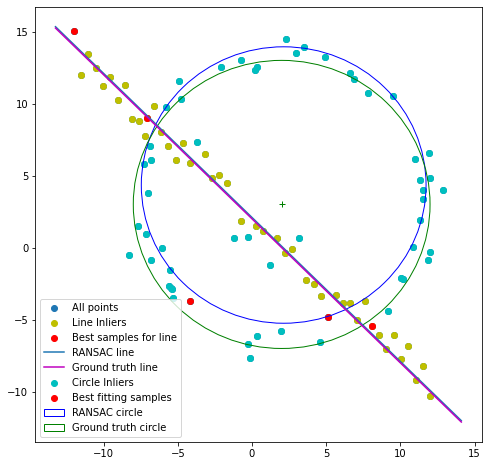

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')


# Plotting the inliers
print("Ratio of inliers =",len(inliers)/len(outliers_data)*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'c', label = "Circle Inliers")

ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")

# Estimate the circle using the inliers using the least square method
# ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC circle", color = 'b')
ax.add_patch(circle)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

ax.legend()
plt.legend()

# 3 Super imposing an image on another image 

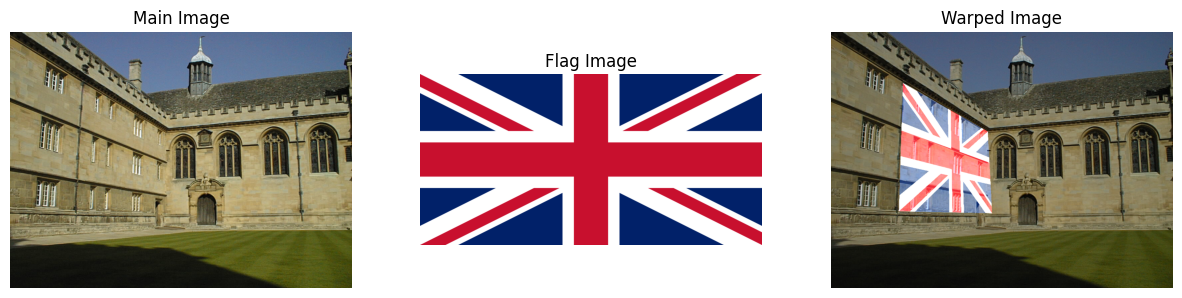

In [30]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

coffs = [0.8, 1, 0]
flag=cv.imread('img/flag.png')
points = []
clicks = 0
def click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x,y])
img = cv.imread('img/Architectural_set.jpg')
cv.imshow('image', img)
cv.setMouseCallback('image', click)
cv.waitKey(0)
cv.destroyAllWindows()

w, h = flag.shape[1], flag.shape[0]
pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
pts_dst = np.array(points)
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))
blended_img = cv.addWeighted(img, coffs[0], im_out, coffs[1], coffs[2])
im=[img, flag, blended_img]
cv.imshow("Blended Image", blended_img)
cv.waitKey(0)
cv.destroyAllWindows()

fig, ax = plt.subplots(1, 3, figsize=(15, 10), facecolor="white")
titles = ['Main Image', 'Flag Image', 'Warped Image']
for j in range(3):
    transformed_img_ = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
    ax[j].axis('off')
    ax[j].imshow(transformed_img_)
    ax[j].set_title(titles[j])

plt.show()

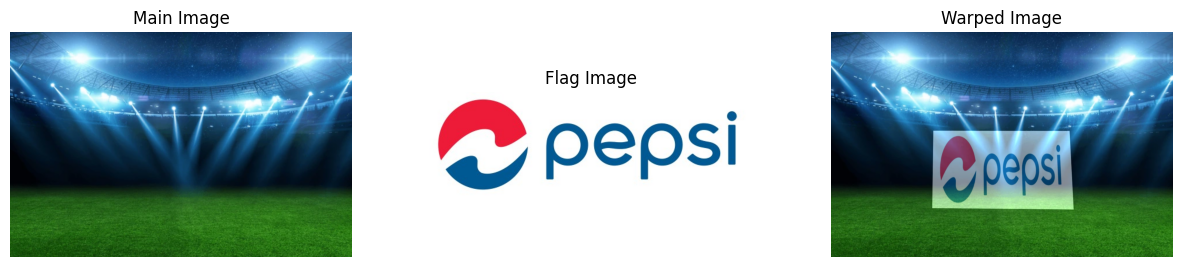

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

coffs = [0.8, 1, 0]
flag=cv.imread('img/pepsi.jpg')
points = []
clicks = 0
def click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x,y])
img = cv.imread('img/ground.png')
cv.imshow('image', img)
cv.setMouseCallback('image', click)
cv.waitKey(0)
cv.destroyAllWindows()

w, h = flag.shape[1], flag.shape[0]
pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
pts_dst = np.array(points)
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))
blended_img = cv.addWeighted(img, coffs[0], im_out, coffs[1], coffs[2])
im=[img, flag, blended_img]
cv.imshow("Blended Image", blended_img)
cv.waitKey(0)
cv.destroyAllWindows()

fig, ax = plt.subplots(1, 3, figsize=(15, 10), facecolor="white")
titles = ['Main Image', 'Flag Image', 'Warped Image']
for j in range(3):
    transformed_img_ = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
    ax[j].axis('off')
    ax[j].imshow(transformed_img_)
    ax[j].set_title(titles[j])

plt.show()

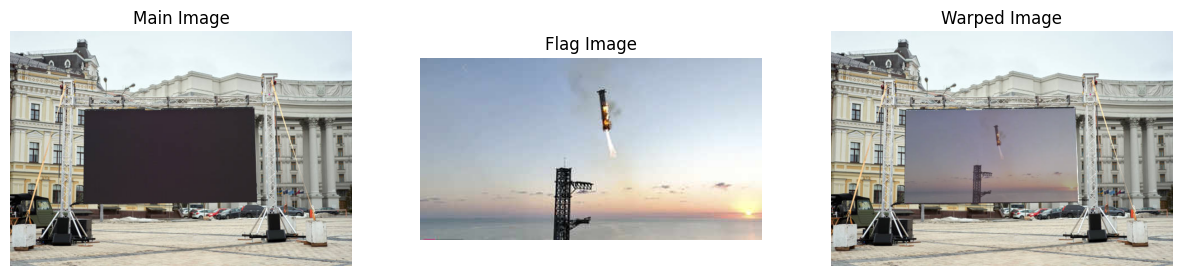

In [25]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

coffs = [0.8, 1, 0]
flag=cv.imread('img/spaceX.jpg')
points = []
clicks = 0
def click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        points.append([x,y])
img = cv.imread('img/big screen.jpg')
cv.imshow('image', img)
cv.setMouseCallback('image', click)
cv.waitKey(0)
cv.destroyAllWindows()

w, h = flag.shape[1], flag.shape[0]
pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
pts_dst = np.array(points)
h, status = cv.findHomography(pts_src, pts_dst)
im_out = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))
blended_img = cv.addWeighted(img, coffs[0], im_out, coffs[1], coffs[2])
im=[img, flag, blended_img]
cv.imshow("Blended Image", blended_img)
cv.waitKey(0)
cv.destroyAllWindows()

fig, ax = plt.subplots(1, 3, figsize=(15, 10), facecolor="white")
titles = ['Main Image', 'Flag Image', 'Warped Image']
for j in range(3):
    transformed_img_ = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
    ax[j].axis('off')
    ax[j].imshow(transformed_img_)
    ax[j].set_title(titles[j])

plt.show()

## 4 Image stitching 

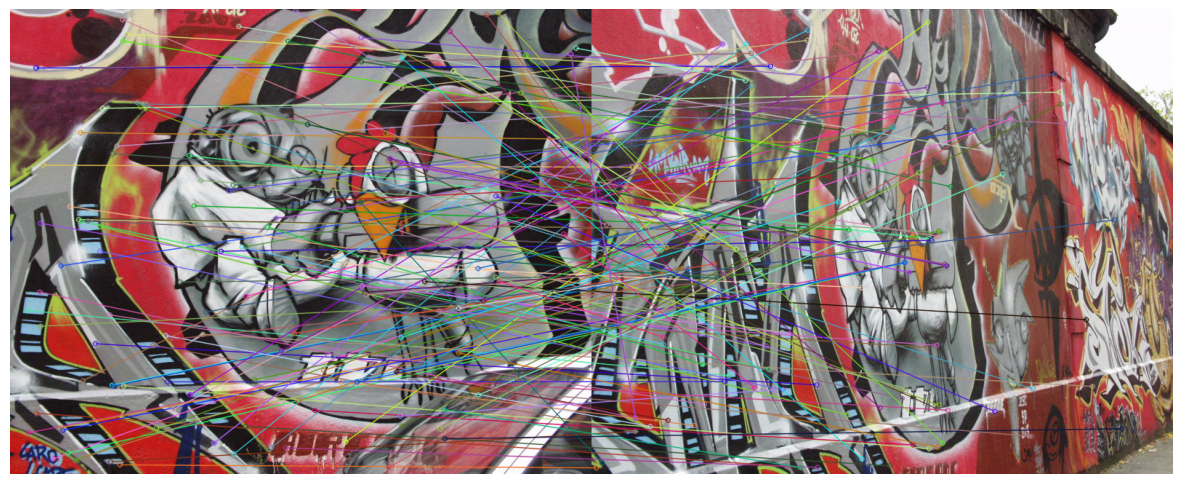

In [42]:
# Import images
img1 = cv.imread('img/graf/img1.ppm')  
img5 = cv.imread('img/graf/img5.ppm')
assert img1 is not None
assert img5 is not None

def sift_match(im1, im2):
    GOOD_MATCH_PERCENT = 0.8
    # Detect sift features
    sift = cv.SIFT_create()
    keypoint_1, descriptors_1 = sift.detectAndCompute(im1,None)
    keypoint_2, descriptors_2 = sift.detectAndCompute(im2,None)
    # Match features.
    matcher = cv.BFMatcher()
    matches = matcher.knnMatch(descriptors_1, descriptors_2, k = 2) 
    # Filter good matches using ratio test in Lowe's paper
    good_matches = []
    for a,b in matches:
        if a.distance < GOOD_MATCH_PERCENT*b.distance:
            good_matches.append(a)
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)
    for i, match in enumerate(good_matches):
        points1[i, :] = keypoint_1[match.queryIdx].pt
        points2[i, :] = keypoint_2[match.trainIdx].pt

    # Plot the matching
    fig, ax = plt.subplots(figsize = (15,15))
    ax.axis('off')
    matched_img = cv.drawMatches(im1, keypoint_1, im2, keypoint_2, good_matches, im2, flags = 2)
    plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
    plt.show()

    result = np.concatenate((points1,points2), axis = 1)
    return result

match1 = sift_match(img1,img5)

In [43]:
def calculateHomography(correspondences):
    temp_list = []
    for points in correspondences:
        p1 = np.matrix([points.item(0), points.item(1), 1]) # (x1,y1)
        p2 = np.matrix([points.item(2), points.item(3), 1]) # (x2,y2)

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), 
              -p2.item(2) * p1.item(2),p2.item(1) * p1.item(0), 
              p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1),
              -p2.item(2) * p1.item(2), 0, 0, 0, p2.item(0) * p1.item(0), 
              p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        temp_list.append(a1)
        temp_list.append(a2)

    assemble_matrix = np.matrix(temp_list)

    #svd composition
    u, s, v = np.linalg.svd(assemble_matrix)
    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    #normalize 
    h = (1/h.item(8)) * h
    return h

# Generate Correspondence Matrices
correspondenceMatrix1_5 = np.matrix(match1)

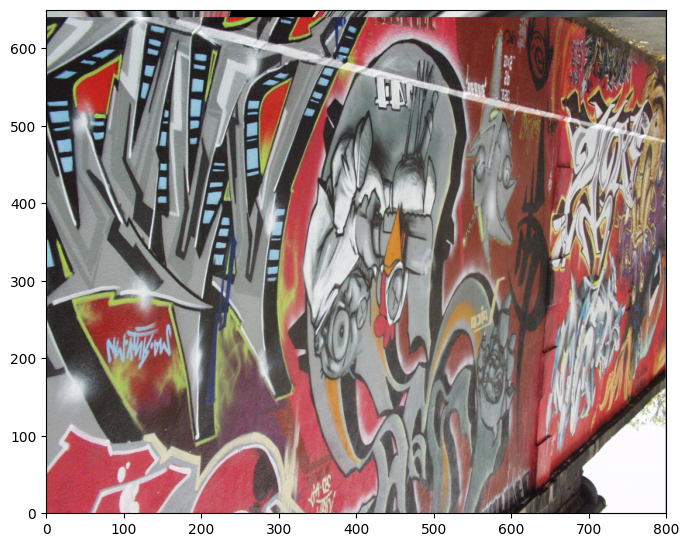

In [47]:
import random
def loss(matched_points, h):
    point1 = np.transpose(np.matrix([matched_points[0].item(0), matched_points[0].item(1), 1]))
    point2 = np.transpose(np.matrix([matched_points[0].item(2), matched_points[0].item(3), 1]))
    
    # Estimate the point after applying the homography
    transformed_point2 = np.dot(h, point1)
    transformed_point2 = (1/transformed_point2.item(2))*transformed_point2

    # Calculate the error between the actual and estimated point
    error = point2 - transformed_point2
    
    return np.linalg.norm(error)

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def ransac(matched_points):
    maxInliers = 0
    best_H = None
    for i in range(10):
        random_points = random_sample(matched_points)

        # Generate the homography 
        homography = calculateHomography(random_points)
        num_inliers = 0

        # Find the inliers
        for i in range(len(matched_points)):
            d = loss(matched_points[i], homography)
            if d < 3:
                num_inliers += 1

        if num_inliers > maxInliers:
            maxInliers = num_inliers
            best_H = homography
    
    return best_H

# Run ransac algorithm
H1_5 = ransac(correspondenceMatrix1_5)

# Warp the image
width = img1.shape[1] + img2.shape[1]
height = img1.shape[0] + img2.shape[0]
result = cv.warpPerspective(img1, H1_5, (width, height))
result[0:img5.shape[0], 0:img5.shape[1]] = img5
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.set_xlim([0, 800])
ax.set_ylim([0, 650])
ax.imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB))
